<a href="https://colab.research.google.com/github/camulro/Aprendizaje-II/blob/sesi%C3%B3n1/10_Pytorch_DL_AE_fashion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![IDAL](https://i.imgur.com/tIKXIG1.jpg)  

#<strong>**Máster en Inteligencia Artificial Avanzada y Aplicada  IA^3**</strong>
---


#<center>Autoencoder simple</center>

Dataset origen: https://github.com/zalandoresearch/fashion-mnist


In [1]:
# Comandos de instalación por si falla la importación
# !conda install numpy pandas pytorch torchvision cpuonly -c pytorch -y
# !pip install matplotlib --upgrade --quiet

In [7]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torchvision.transforms as transforms
import torch.optim as optim

import torch.nn.functional as F
import os
from torchvision.datasets import FashionMNIST
from torch.utils.data import DataLoader
from torchvision.utils import save_image
from torchvision.utils import make_grid
%matplotlib inline

In [3]:
# constants
NUM_EPOCHS = 50
LEARNING_RATE = 1e-3
BATCH_SIZE = 128
# image transformations
transform = transforms.Compose([
    transforms.ToTensor(),
])

## Preparación de los datos

In [4]:
trainset = FashionMNIST(
    root='./data',
    train=True, 
    download=True,
    transform=transform
)
testset = FashionMNIST(
    root='./data',
    train=False,
    download=True,
    transform=transform
)
trainloader = DataLoader(
    trainset, 
    batch_size=BATCH_SIZE,
    shuffle=True
)
testloader = DataLoader(
    testset, 
    batch_size=BATCH_SIZE, 
    shuffle=True
)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



images.shape: torch.Size([128, 1, 28, 28])


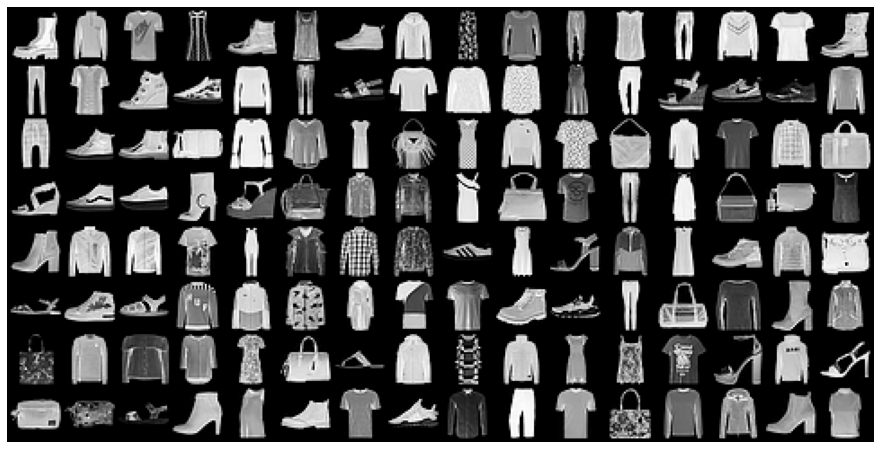

In [8]:
for images, _ in trainloader:
    print('images.shape:', images.shape)
    plt.figure(figsize=(16,8))
    plt.axis('off')
    plt.imshow(make_grid(images, nrow=16).permute((1, 2, 0)))
    break

In [9]:
# utility functions
def get_device():
    if torch.cuda.is_available():
        device = 'cuda:0'
    else:
        device = 'cpu'
    return device
def make_dir():
    image_dir = 'FashionMNIST_Images'
    if not os.path.exists(image_dir):
        os.makedirs(image_dir)
def save_decoded_image(img, epoch):
    img = img.view(img.size(0), 1, 28, 28)
    save_image(img, './FashionMNIST_Images/linear_ae_image{}.png'.format(epoch))

## Modelo

In [10]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        # encoder
        self.enc1 = nn.Linear(in_features=784, out_features=256)
        self.enc2 = nn.Linear(in_features=256, out_features=128)
        self.enc3 = nn.Linear(in_features=128, out_features=64)
        self.enc4 = nn.Linear(in_features=64, out_features=32)
        self.enc5 = nn.Linear(in_features=32, out_features=16)
        # decoder 
        self.dec1 = nn.Linear(in_features=16, out_features=32)
        self.dec2 = nn.Linear(in_features=32, out_features=64)
        self.dec3 = nn.Linear(in_features=64, out_features=128)
        self.dec4 = nn.Linear(in_features=128, out_features=256)
        self.dec5 = nn.Linear(in_features=256, out_features=784)
    def forward(self, x):
        x = F.relu(self.enc1(x))
        x = F.relu(self.enc2(x))
        x = F.relu(self.enc3(x))
        x = F.relu(self.enc4(x))
        x = F.relu(self.enc5(x))
        x = F.relu(self.dec1(x))
        x = F.relu(self.dec2(x))
        x = F.relu(self.dec3(x))
        x = F.relu(self.dec4(x))
        x = F.relu(self.dec5(x))
        return x
net = Autoencoder()
print(net)

Autoencoder(
  (enc1): Linear(in_features=784, out_features=256, bias=True)
  (enc2): Linear(in_features=256, out_features=128, bias=True)
  (enc3): Linear(in_features=128, out_features=64, bias=True)
  (enc4): Linear(in_features=64, out_features=32, bias=True)
  (enc5): Linear(in_features=32, out_features=16, bias=True)
  (dec1): Linear(in_features=16, out_features=32, bias=True)
  (dec2): Linear(in_features=32, out_features=64, bias=True)
  (dec3): Linear(in_features=64, out_features=128, bias=True)
  (dec4): Linear(in_features=128, out_features=256, bias=True)
  (dec5): Linear(in_features=256, out_features=784, bias=True)
)


In [11]:
criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=LEARNING_RATE)

##Dispositivo (GPU o CPU)

In [12]:
# get the computation device
device = get_device()
print(device)
# load the neural network onto the device
net.to(device)
make_dir()


cuda:0


## Entrenamiento

In [14]:
def train(net, trainloader, NUM_EPOCHS):
    train_loss = []
    for epoch in range(NUM_EPOCHS):
        running_loss = 0.0
        for data in trainloader:
            img, _ = data
            img = img.to(device)
            img = img.view(img.size(0), -1)
            optimizer.zero_grad()
            outputs = net(img)
            loss = criterion(outputs, img)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        
        loss = running_loss / len(trainloader)
        train_loss.append(loss)
        print('Epoch {} of {}, Train Loss: {:.3f}'.format(
            epoch+1, NUM_EPOCHS, loss))
        if epoch % 5 == 0:
            save_decoded_image(outputs.cpu().data, epoch) #cada 5 epoch guarda la imagen para tener un registro de como esta la imagen reconstruida
    return train_loss
def test_image_reconstruction(net, testloader):
     for batch in testloader:
        img, _ = batch
        img = img.to(device)
        img = img.view(img.size(0), -1)
        outputs = net(img)
        outputs = outputs.view(outputs.size(0), 1, 28, 28).cpu().data
        save_image(outputs, 'fashionmnist_reconstruction.png')
        break

Epoch 1 of 50, Train Loss: 0.074
Epoch 2 of 50, Train Loss: 0.039
Epoch 3 of 50, Train Loss: 0.033
Epoch 4 of 50, Train Loss: 0.029
Epoch 5 of 50, Train Loss: 0.027
Epoch 6 of 50, Train Loss: 0.026
Epoch 7 of 50, Train Loss: 0.025
Epoch 8 of 50, Train Loss: 0.024
Epoch 9 of 50, Train Loss: 0.023
Epoch 10 of 50, Train Loss: 0.023
Epoch 11 of 50, Train Loss: 0.022
Epoch 12 of 50, Train Loss: 0.022
Epoch 13 of 50, Train Loss: 0.022
Epoch 14 of 50, Train Loss: 0.021
Epoch 15 of 50, Train Loss: 0.020
Epoch 16 of 50, Train Loss: 0.020
Epoch 17 of 50, Train Loss: 0.020
Epoch 18 of 50, Train Loss: 0.020
Epoch 19 of 50, Train Loss: 0.020
Epoch 20 of 50, Train Loss: 0.019
Epoch 21 of 50, Train Loss: 0.019
Epoch 22 of 50, Train Loss: 0.019
Epoch 23 of 50, Train Loss: 0.019
Epoch 24 of 50, Train Loss: 0.018
Epoch 25 of 50, Train Loss: 0.018
Epoch 26 of 50, Train Loss: 0.018
Epoch 27 of 50, Train Loss: 0.018
Epoch 28 of 50, Train Loss: 0.018
Epoch 29 of 50, Train Loss: 0.017
Epoch 30 of 50, Train L

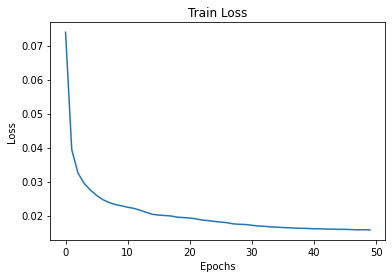

In [15]:
# train the network
train_loss = train(net, trainloader, NUM_EPOCHS)
plt.figure()
plt.plot(train_loss)
plt.title('Train Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.savefig('deep_ae_fashionmnist_loss.png')
# test the network
test_image_reconstruction(net, testloader)

##Visualizamos resultados

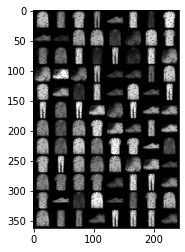

In [ ]:
import matplotlib.image as mpimg

img=mpimg.imread('/content/FashionMNIST_Images/linear_ae_image0.png')

imgplot = plt.imshow(img)

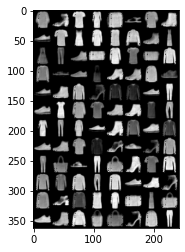

In [ ]:
img=mpimg.imread('/content/FashionMNIST_Images/linear_ae_image25.png')

imgplot = plt.imshow(img)

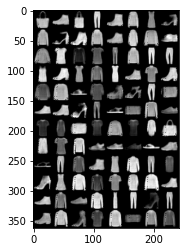

In [ ]:
img=mpimg.imread('/content/FashionMNIST_Images/linear_ae_image45.png')

imgplot = plt.imshow(img)

## Fin del Notebook

Referencias y modelos empleados para el Notebook: 

*   Documentación de [Pytorch](https://pytorch.org/docs/stable/index.html) 
*   [PyTorch Tutorial for Deep Learning Researchers](https://github.com/yunjey/pytorch-tutorial) by Yunjey Choi
*   [FastAI](https://www.fast.ai/) development notebooks by Jeremy Howard.
*   Documentación y cursos en [Pierian Data](https://www.pieriandata.com/)
*   Tutoriales y notebooks del curso "Deep Learning with Pytorch: Zero to GANs" de [Aakash N S](https://jovian.ai/aakashns)
* [A visual proof that neural networks can compute any function](http://neuralnetworksanddeeplearning.com/chap4.html), también conocido como Teorema de Aproximación Universal
* [But what *is* a neural network?](https://www.youtube.com/watch?v=aircAruvnKk) - Una introducción muy intuitiva a lo que son las redes neuronales y lo que implican las capas ocultas.